In [130]:
import csv
udacity_csv = 'udacity_data/driving_log.csv'

# Step 1: Read the CSV File
lines = []
with open(udacity_csv) as f:
    reader = csv.reader(f)
    for line in reader:
        lines.append(line)
        
print('Total Samples: ', len(lines))

# count = 0
# new_sample = []
# for sample in lines:
    
    
#     center_angle = float(sample[3])
#     if center_angle == 0.0:
#         count = count + 1
#         if np.random.uniform() < 0.2:
#             new_sample.append(sample)
#     else:
#         new_sample.append(sample)

# lines = new_sample

# print('Adjusted Samples: ', len(lines))

Total Samples:  8036


In [131]:
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(lines, test_size=0.2)
print('Total Training Samples', len(train_samples))
print('Total Validation Samples', len(validation_samples))

Total Training Samples 6428
Total Validation Samples 1608


#### Helpers

In [124]:
import cv2
import numpy as np
from sklearn.utils import shuffle
import os
dir_path = os.getcwd()

def shift_img(image, angle):
    """ shift image randomly
    	source: https://github.com/windowsub0406/Behavior-Cloning/blob/master/model.py """
    max_shift = 55
    max_ang = 0.14  # ang_per_pixel = 0.0025

    rows, cols, _ = image.shape

    random_x = np.random.randint(-max_shift, max_shift + 1)
    steer = angle + (random_x / max_shift) * max_ang
    if abs(steer) > 1:
        dst_steer = -1 if (steer < 0) else 1

    mat = np.float32([[1, 0, random_x], [0, 1, 0]])
    dst_img = cv2.warpAffine(image, mat, (cols, rows))
    
    return dst_img, steer

def get_image_and_angle(batch_sample):
    # Image
    random = np.random.randint(3)
    path = batch_sample[random].strip()
    if path.split('/')[0] == 'IMG':
        path = dir_path + '/udacity_data/' + path

    # Angle
    angle = float(batch_sample[3])
    if random == 1:
        angle = angle + 0.22
    if random == 2:
        angle = angle - 0.22

    return path, angle

def flip_image(image, angle):
    flip_image = image.copy()
    flip_angle = angle
    num = np.random.randint(2)
    if num == 0:
        flip_image, flip_angle = cv2.flip(image, 1), -angle

    return flip_image, flip_angle

def augment_brightness(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random = np.random.randint(2)

    if random == 0:
        random_bright = 0.2 + np.random.uniform(0.2, 0.6)
        hsv_img[:,:,2] = hsv_img[:,:,2] * random_bright
    hsv_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

    return hsv_img

def preprocess(image, angle):
    image, angle = shift_img(image, angle)
    image, angle = flip_image(image, angle)
    image = augment_brightness(image)

    return image, angle

def train_generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]

            images = []
            steering_angles = []
            for batch_sample in batch_samples:
                image, angle = get_image_and_angle(batch_sample)
                image = cv2.imread(image)

                image, angle = preprocess(image, angle)
                images.append(image)
                steering_angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(steering_angles)
            yield shuffle(X_train, y_train)

def valid_generator(samples, batch_size=32):
    image_set = np.zeros((len(validation_samples), 160, 320, 3))
    angles_set = np.zeros(len(validation_samples))

    for i in range(len(samples)):
        # Image
        sample = samples[i]
        path = sample[0].strip()
        if path.split('/')[0] == 'IMG':
            path = dir_path + '/udacity_data/' + path
        image = cv2.imread(path)
        # img = image[60:136,0:image.shape[1],:]
        image_set[i] = image

        # Angle
        angles_set[i] = float(sample[3])

        return image_set, angles_set


In [125]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# original_img, original_steering = get_image_and_angle(train_samples[0])
# original_img = cv2.imread(original_img)

# shift_image, shift_steering = shift_img(original_img, original_steering)

# plt.subplot(1,2,1);
# plt.imshow(original_img);
# plt.subplot(1,2,2);
# plt.imshow(shift_image);
# plt.show()

In [126]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# original_img, original_steering = get_image_and_angle(train_samples[0])
# original_img = cv2.imread(original_img)

# flip_image, flip_steering = flip_image(original_img, original_steering)

# plt.subplot(1,2,1);
# plt.imshow(original_img);
# plt.subplot(1,2,2);
# plt.imshow(flip_image);
# plt.show()

In [127]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# original_img, original_steering = get_image_and_angle(train_samples[0])
# original_img = cv2.imread(original_img)

# aug_br_image = augment_brightness(original_img)

# plt.subplot(1,2,1);
# plt.imshow(original_img);
# plt.subplot(1,2,2);
# plt.imshow(aug_br_image);
# plt.show()

#### Model

In [128]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, ELU
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam


model = Sequential()
# normalization
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((72,25),(0,0))))

# nvidia nn
model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu', name="conv0"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1)))

model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu', name="conv1"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), border_mode='same'))

model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu', name="conv2"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), border_mode='same'))

model.add(Convolution2D(64,3,3,activation='relu', name="conv3"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), border_mode='same'))

model.add(Convolution2D(64,3,3, activation='relu', name="conv4"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), border_mode='same'))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1164, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# model.summary()

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='mse')

Epoch 1/10
3615/3615 [==============================] - 54s - loss: 0.0536 - val_loss: 0.0017
Epoch 2/10
3615/3615 [==============================] - 65s - loss: 0.0391 - val_loss: 6.7026e-04
Epoch 3/10
3615/3615 [==============================] - 81s - loss: 0.0360 - val_loss: 0.0021
Epoch 4/10
3615/3615 [==============================] - 70s - loss: 0.0349 - val_loss: 0.0017
Epoch 5/10
3615/3615 [==============================] - 68s - loss: 0.0332 - val_loss: 0.0037
Epoch 6/10
3615/3615 [==============================] - 71s - loss: 0.0325 - val_loss: 0.0010
Epoch 7/10
3615/3615 [==============================] - 70s - loss: 0.0306 - val_loss: 1.7319e-04
Epoch 8/10
3615/3615 [==============================] - 70s - loss: 0.0310 - val_loss: 0.0055
Epoch 9/10
3615/3615 [==============================] - 73s - loss: 0.0293 - val_loss: 0.0026
Epoch 10/10
3615/3615 [==============================] - 75s - loss: 0.0280 - val_loss: 6.0674e-05
dict_keys(['val_loss', 'loss'])


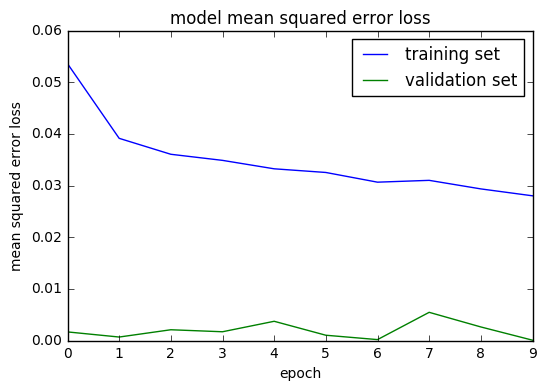

In [129]:
import matplotlib.pyplot as plt

train_generator = train_generator(train_samples, batch_size=32)
valid_generator = valid_generator(validation_samples, batch_size=32)

history_object = model.fit_generator(
    train_generator,
    samples_per_epoch=len(train_samples),
    validation_data=valid_generator,
    nb_epoch=10,
    verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

# model.save('model-hip.h5')
# K.clear_session()